In [ ]:
import numpy as np
from keras.backend import int_shape
from keras.models import Model
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, UpSampling2D, UpSampling3D, Add, BatchNormalization, Input, Activation, Lambda, Concatenate
 
 
def res_unet(filter_root, depth, n_class=2, input_size=(256, 256, 1), activation='relu', batch_norm=True, final_activation='softmax'):
 
    inputs = Input(input_size)
    x = inputs
    # Dictionary for long connections
    long_connection_store = {}
 
    if len(input_size) == 3:
        Conv = Conv2D
        MaxPooling = MaxPooling2D
        UpSampling = UpSampling2D
    elif len(input_size) == 4:
        Conv = Conv3D
        MaxPooling = MaxPooling3D
        UpSampling = UpSampling3D
 
    # Down sampling
    for i in range(depth):
        out_channel = 2**i * filter_root
 
        # Residual/Skip connection
        res = Conv(out_channel, kernel_size=1, padding='same', use_bias=False, name="Identity{}_1".format(i))(x)
 
        # First Conv Block with Conv, BN and activation
        conv1 = Conv(out_channel, kernel_size=3, padding='same', name="Conv{}_1".format(i))(x)
        if batch_norm:
            conv1 = BatchNormalization(name="BN{}_1".format(i))(conv1)
        act1 = Activation(activation, name="Act{}_1".format(i))(conv1)
 
        # Second Conv block with Conv and BN only
        conv2 = Conv(out_channel, kernel_size=3, padding='same', name="Conv{}_2".format(i))(act1)
        if batch_norm:
            conv2 = BatchNormalization(name="BN{}_2".format(i))(conv2)
 
        resconnection = Add(name="Add{}_1".format(i))([res, conv2])
 
        act2 = Activation(activation, name="Act{}_2".format(i))(resconnection)
 
        # Max pooling
        if i < depth - 1:
            long_connection_store[str(i)] = act2
            x = MaxPooling(padding='same', name="MaxPooling{}_1".format(i))(act2)
        else:
            x = act2
 
    # Upsampling
    for i in range(depth - 2, -1, -1):
        out_channel = 2**(i) * filter_root
 
        # long connection from down sampling path.
        long_connection = long_connection_store[str(i)]
 
        up1 = UpSampling(name="UpSampling{}_1".format(i))(x)
        up_conv1 = Conv(out_channel, 2, activation='relu', padding='same', name="upConv{}_1".format(i))(up1)
 
        #  Concatenate.
        up_conc = Concatenate(axis=-1, name="upConcatenate{}_1".format(i))([up_conv1, long_connection])
 
        #  Convolutions
        up_conv2 = Conv(out_channel, 3, padding='same', name="upConv{}_2".format(i))(up_conc)
        if batch_norm:
            up_conv2 = BatchNormalization(name="upBN{}_1".format(i))(up_conv2)
        up_act1 = Activation(activation, name="upAct{}_1".format(i))(up_conv2)
 
        up_conv2 = Conv(out_channel, 3, padding='same', name="upConv{}_3".format(i))(up_act1)
        if batch_norm:
            up_conv2 = BatchNormalization(name="upBN{}_2".format(i))(up_conv2)
 
        # Residual/Skip connection
        res = Conv(out_channel, kernel_size=1, padding='same', use_bias=False, name="upIdentity{}_1".format(i))(up_conc)
 
        resconnection = Add(name="upAdd{}_1".format(i))([res, up_conv2])
 
        x = Activation(activation, name="upAct{}_2".format(i))(resconnection)
 
    # Final convolution
    output = Conv(n_class, 1, padding='same', activation=final_activation, name='output')(x)
 
    return Model(inputs, outputs=output, name='Res-UNet')

In [ ]:
m=res_unet(16, 7, n_class=2, input_size=(256, 256, 1), activation='relu', batch_norm=True, final_activation='softmax')

In [ ]:
m.summary()

Model: "Res-UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
Conv0_1 (Conv2D)                (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
BN0_1 (BatchNormalization)      (None, 256, 256, 16) 64          Conv0_1[0][0]                    
__________________________________________________________________________________________________
Act0_1 (Activation)             (None, 256, 256, 16) 0           BN0_1[0][0]                      
___________________________________________________________________________________________

In [ ]:
! kaggle

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: too few arguments


In [ ]:
! cp kaggle.json /root/.kaggle/kaggle.json

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download saputrahas/dataset-image-super-resolution

100% 2.09G/2.09G [00:25<00:00, 24.1MB/s]
100% 2.09G/2.09G [00:25<00:00, 86.9MB/s]


In [ ]:
!unzip -qq dataset-image-super-resolution

In [ ]:
import os

In [ ]:
data_dir = "dataset-upload-to-kaggle/finished/train/dataraw/hires"
all_images = os.listdir(data_dir)

In [ ]:
len(all_images)

4128

In [ ]:

print(all_images[0])

dt_train_2888.jpg


In [ ]:
xImages = all_images[:len(all_images)//2]
yImages = all_images[len(all_images)//2:]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
path = data_dir + "/" + i
print(path)

dataset-upload-to-kaggle/finished/train/dataraw/hires/dt_train_627.jpg


In [ ]:
X_train = []
for i in xImages:
  path = data_dir + "/" + i
  q = plt.imread(path)
  X_train.append(q)

In [ ]:
X_train[0].shape

(720, 1024, 3)

In [ ]:
len(X_train)

2064

In [ ]:
Y_train = []
for i in yImages:
  path = data_dir + "/" + i
  p = plt.imread(path)
  Y_train.append(p)

In [ ]:
m.compile(optimizer='adam',loss='categorical_crossentropy')


In [ ]:
m.fit(X_train[0],Y_train[0],epochs=10)

ValueError: ignored

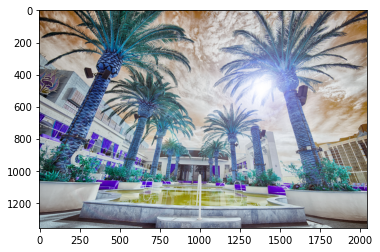

In [ ]:
plt.imshow(x)

In [ ]:
y=cv2.imread("0003x8.png")

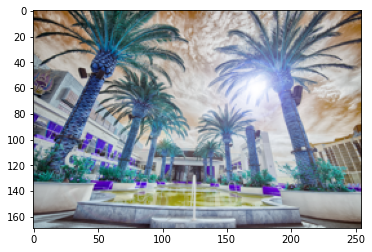

In [ ]:
plt.imshow(y)

In [ ]:
from PIL  import Image

In [ ]:
foo=Image.open("0003.jpg")

In [ ]:
foo

In [ ]:
foo.size

(2040, 1356)

In [ ]:
 foo = foo.resize((160,300),Image.ANTIALIAS)

In [ ]:
# The saved downsized image size is 24.8kb
 >>> foo.save("path\\to\\save\\image_scaled_opt.jpg",optimize=True,quality=95)
 # The saved downsized image size is 22.9kb

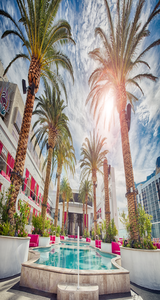

In [ ]:
foo

In [ ]:
for i in 